<a href="https://colab.research.google.com/github/romainjulian/ProgrammingAssignment2/blob/master/M%C3%A9moire_BELARBI_JULIAN_PART_3_Section_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **PART 3 - Section 2 : Predction et Allocation d'un portefeuille de 3 actions**

In [0]:
import math
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pandas_datareader as web
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import scipy
from scipy import optimize

import cvxopt as opt  
from cvxopt import blas, solvers  

/usr/local/lib/python3.6/dist-packages/pandas_datareader/compat/__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal
Using TensorFlow backend.


In [0]:
LVMH1 = web.get_data_yahoo("MC.PA", "2012-01-01", "2019-12-31").reset_index()
AIRB1 = web.get_data_yahoo("AIR.PA", "2012-01-01", "2019-12-31").reset_index()
TOT1 = web.get_data_yahoo("TOT", "2012-01-01", "2019-12-31").reset_index()

In [0]:
LVMH = pd.DataFrame(LVMH1['Adj Close']).set_index(LVMH1['Date'])
AIRB = pd.DataFrame(AIRB1['Adj Close']).set_index(AIRB1['Date'])
TOT = pd.DataFrame(TOT1['Adj Close']).set_index(TOT1['Date'])

In [0]:
pf = [LVMH, AIRB, TOT]
columns = ['LVMH', 'AIRB', 'TOT']

In [0]:
data = pd.merge(LVMH, AIRB, on='Date')
data = pd.merge(data, TOT, on='Date')
data.columns=columns
data

,LVMH,AIRB,TOT
Date,,,
2012-01-03,93.622231,20.311575,33.142235
2012-01-04,92.578751,20.365461,33.015903
2012-01-05,91.785683,20.634899,32.346371
2012-01-06,90.909134,20.531271,32.055805
2012-01-09,91.869171,20.614174,32.371628
...,...,...,...
2019-12-23,408.519135,128.572189,53.187866
2019-12-24,408.815338,128.920776,52.936611
2019-12-27,412.270660,129.056335,53.129883


OPTIMISATION DE PORTEFEUILLE A PARTIR DE RENDEMENTS PREDITS

1. Prediction des rendements de 3 titres

In [0]:
predictions = pd.DataFrame()
for i in range(len(pf)):

  dataset = data[columns[i]].values
  training_len = math.ceil(len(dataset)*.8)

  # SCALE DATA 
  dataset = dataset.astype('float32')
  dataset = np.reshape(dataset, (-1, 1))
  scaler=MinMaxScaler(feature_range=(0,1))
  scaled_data=scaler.fit_transform(dataset)

  train=scaled_data[0:training_len,:]

  x_train=[]
  y_train=[]
  stock_history= 60
  for i in range (stock_history, len(train)):
    x_train.append(train[i-stock_history:i,0])
    y_train.append(train[i,0])

  # TrainingLSTM model 
  x_train,y_train=np.array(x_train),np.array(y_train)
  x_train=np.reshape(x_train,(x_train.shape[0],x_train.shape[1],1))

  model=Sequential()
  model.add(LSTM(50,return_sequences=True,input_shape=(x_train.shape[1],1)))
  model.add(LSTM(50,return_sequences=False))
  model.add(Dense(25))
  model.add(Dense(1))

  #Compile the model
  model.compile(optimizer='adam',loss='mean_squared_error')

  #Train the model
  model.fit(x_train,y_train,batch_size=1, epochs=2)

  test_data=scaled_data[training_len - stock_history:,:]
  x_test=[]
  y_test=dataset[training_len:,:]

  for i in range (stock_history,len(test_data)):
    x_test.append(test_data[i-stock_history:i,0])

  x_test=np.array(x_test)

  #Reshape the data (LSTM 3 dimensional and our current model is 2 dim)
  x_test=np.reshape(x_test,(x_test.shape[0],x_test.shape[1],1))
  
  #Get the models predicted price value
  predictions_s=pd.DataFrame(model.predict(x_test))
  predictions=pd.concat([predictions, pd.DataFrame(scaler.inverse_transform(predictions_s))], axis=1)

predictions.columns = columns

Epoch 1/2
1532/1532 [==============================] - 54s 35ms/step - loss: 7.0402e-04
Epoch 2/2
1532/1532 [==============================] - 53s 35ms/step - loss: 3.1516e-04
Epoch 1/2
1532/1532 [==============================] - 55s 36ms/step - loss: 9.2613e-04
Epoch 2/2
1532/1532 [==============================] - 55s 36ms/step - loss: 3.9312e-04
Epoch 1/2
1532/1532 [==============================] - 54s 35ms/step - loss: 0.0028
Epoch 2/2
1532/1532 [==============================] - 53s 35ms/step - loss: 9.6070e-04


In [0]:
#Rendement prédiction
rend = np.log(predictions/predictions.shift(1)).dropna()
rend=rend.reset_index(drop=True)
rend

,LVMH,AIRB,TOT
0,-0.006058,-0.004384,0.009681
1,-0.006221,-0.003056,0.013170
2,-0.001324,0.001610,0.014295
3,0.002701,0.003390,0.008190
4,0.007428,0.002554,0.000933
...,...,...,...
391,0.003809,0.005655,0.000110
392,0.005983,0.005352,0.004817
393,0.005500,0.004539,0.001102
394,0.005987,0.003460,0.001355


2. Portefeuille Maximisant le ratio de sharpe à partir des prédictions


In [0]:
# Simulation de ptf Monte Carlo
np.random.seed(42)
num_ports = 6000
all_weights = np.zeros((num_ports, len(rend.columns)))
ret_arr = np.zeros(num_ports)
vol_arr = np.zeros(num_ports)
sharpe_arr = np.zeros(num_ports)

for x in range(num_ports):
    # Poids
    weights = np.array(np.random.random(rend.shape[1]))
    weights = weights/np.sum(weights)
    
    # Save weights
    all_weights[x,:] = weights
    
    # Expected return
    ret_arr[x] = np.sum( (rend.mean() * weights * 252))
    
    # Expected volatility
    vol_arr[x] = np.sqrt(np.dot(weights.T, np.dot(rend.cov()*252, weights)))
    
    # Sharpe Ratio
    sharpe_arr[x] = ret_arr[x]/vol_arr[x]

In [0]:
max_sr_vol = vol_arr[sharpe_arr.argmax()]
max_sr_ret = ret_arr[sharpe_arr.argmax()]

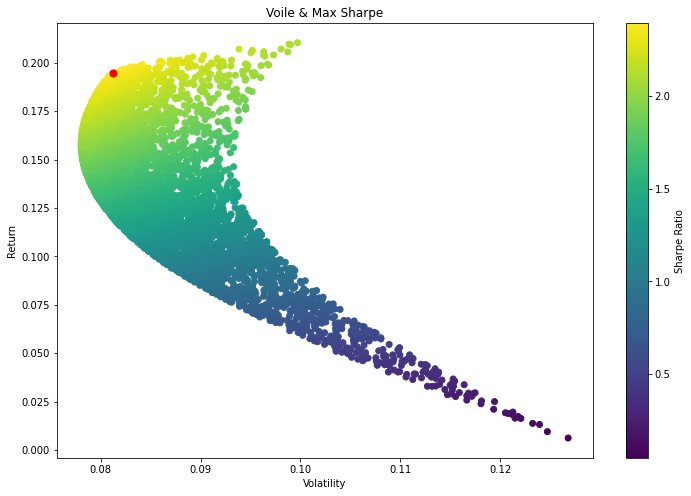

In [0]:

plt.figure(figsize=(12,8))
plt.scatter(vol_arr, ret_arr, c=sharpe_arr, cmap='viridis')
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Volatility')
plt.ylabel('Return')
plt.title('Ptf Maximisant le ratio de Sharp en fonction des valeurs prédites')
plt.scatter(max_sr_vol, max_sr_ret,c='red', s=50) # red dot
plt.title("Voile & Max Sharpe")
plt.show()

In [0]:
# Ptf Ratio de sharpe maximum
weight_max_sharpe_ratio_pf=all_weights[sharpe_arr.argmax(),:]
print('Le portefeuille maximisant le ratio de sharpe à partir des prévisions est:')
print(weight_max_sharpe_ratio_pf)
print('Pour un rendement de :', round(ret_arr[sharpe_arr.argmax()]*100, 2), '%')
print('Et une volatilité de :', round(vol_arr[sharpe_arr.argmax()]*100, 2), '%')
print('Pour un ratio de Sharpe de: ', sharpe_arr.max())

# Verification somme poids = 1
print(np.sum(weight_max_sharpe_ratio_pf))

Le portefeuille maximisant le ratio de sharpe à partir des prévisions est:
[4.13802018e-01 5.85933318e-01 2.64664045e-04]
Pour un rendement de : 19.46 %
Et une volatilité de : 8.12 %
Pour un ratio de Sharpe de:  2.395268621324182
1.0


3. Portefeuille Min-Variance à partir des prédictions

In [0]:
def check_sum(weights):
    # renvoie 0.0 si somme = 1
    return np.sum(weights)-1

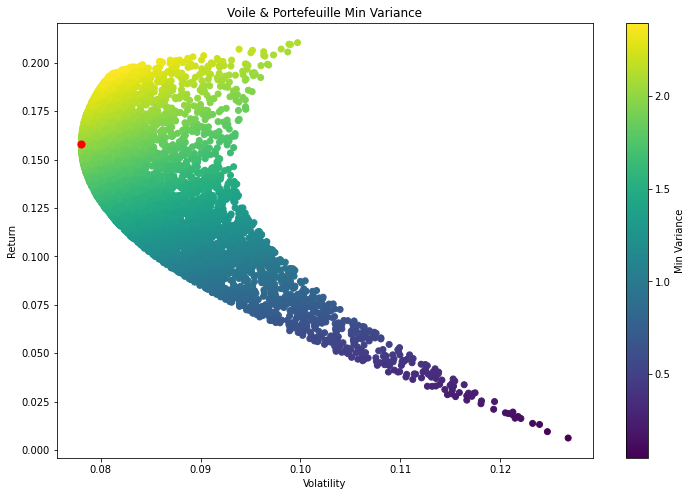

In [0]:
# Ptf min variance
plt.figure(figsize=(12,8))
plt.scatter(vol_arr, ret_arr, c=sharpe_arr, cmap='viridis')
plt.colorbar(label='Min Variance')
plt.xlabel('Volatility')
plt.ylabel('Return')
plt.scatter(vol_arr[vol_arr.argmin()], ret_arr[vol_arr.argmin()],c='red', s=50) # red dot
plt.title('Voile & Portefeuille Min Variance')
plt.show()

In [0]:
# Ptf min variance
weight_min_var_pf=all_weights[vol_arr.argmin(),:]
print('Le portefeuille Min-Variance est:',weight_min_var_pf)
print('Pour un rendement de :', round(ret_arr[vol_arr.argmin()]*100, 2), '%')
print('Et une volatilité de :', round(vol_arr[vol_arr.argmin()]*100, 2), '%')
print('Pour un ratio de Sharpe de: ', sharpe_arr[vol_arr.argmin()])
# Verification somme poids = 1
check_sum(weight_min_var_pf)

Le portefeuille Min-Variance est: [0.19956639 0.63005272 0.17038089]
Pour un rendement de : 15.8 %
Et une volatilité de : 7.8 %
Pour un ratio de Sharpe de:  2.0251893983638998


0.0

4. Application des portefeuilles au vrais valeurs

In [0]:
return_lvmh=np.log(LVMH/LVMH.shift(1)).dropna()
return_lvmh=return_lvmh.reset_index(drop=True)
return_lvmh.rename(columns={'Adj Close':'Rdmt LVMH'}, inplace=True)
return_lvmh = pd.DataFrame(return_lvmh).set_index(LVMH1['Date'][1:])

return_airb=np.log(AIRB/AIRB.shift(1)).dropna()
return_airb=return_airb.reset_index(drop=True)
return_airb.rename(columns={'Adj Close':'Rdmt AIRB'}, inplace=True)
return_airb= pd.DataFrame(return_airb).set_index(AIRB1['Date'][1:])

return_tot=np.log(TOT/TOT.shift(1)).dropna()
return_tot=return_tot.reset_index(drop=True)
return_tot.rename(columns={'Adj Close':'Rdmt TOT'}, inplace=True)
return_tot= pd.DataFrame(return_tot).set_index(TOT1['Date'][1:])


data_return = pd.merge(return_lvmh, return_airb, on='Date')
data_return= pd.merge(data_return, return_tot, on='Date')

true_rend=data_return[training_len:].reset_index(drop=True)
true_rend


,Rdmt LVMH,Rdmt AIRB,Rdmt TOT
0,-0.008381,0.005978,0.000990
1,0.016195,0.021150,0.010660
2,0.008575,0.001709,0.000163
3,0.016610,-0.005843,-0.003104
4,-0.010879,0.010252,0.009445
...,...,...,...
391,0.008007,0.006801,0.012248
392,0.000725,0.002708,-0.004735
393,0.008417,0.001051,-0.002362
394,-0.007210,-0.024918,0.001999


In [0]:
# Application des portefeuilles
true_rend_mat=np.array(true_rend)

def get_ret_vol_sr(weights):
    weights = np.array(weights)
    ret = np.sum(true_rend_mat.mean() * weights) * 252
    vol = np.sqrt(np.dot(weights.T, np.dot(rend.cov()*252, weights)))
    sr = ret/vol
    return np.array([ret, vol, sr])

res_min_var_prev=get_ret_vol_sr(weight_min_var_pf)
res_shapre_prev=get_ret_vol_sr(weight_max_sharpe_ratio_pf)

print("Min Var Previsions",res_min_var_prev,"Sharpe Previsions", res_shapre_prev)

Min Var Previsions [0.12577534 0.07803509 1.61177924] Sharpe Previsions [0.12577534 0.08123686 1.54825463]


OPTIMISATION DE PORTEFEUILLE A PARTIR DE RENDEMENTS HISTORIQUES


In [0]:
# Echantillon données
sample=data_return[training_len-len(true_rend):training_len].reset_index(drop=True)
sample

,Rdmt LVMH,Rdmt AIRB,Rdmt TOT
0,-0.006569,-0.026614,-0.007019
1,0.006867,0.036956,-0.006651
2,-0.000298,0.000902,0.008928
3,-0.000298,-0.008149,-0.002691
4,-0.014393,-0.015575,-0.010626
...,...,...,...
391,-0.016643,-0.017033,-0.026998
392,0.003777,-0.006183,-0.005718
393,0.002619,-0.001425,-0.029426
394,-0.018960,0.001234,-0.012564


In [0]:
# Simulation de ptf Monte Carlo
np.random.seed(42)
num_ports = 6000
all_weights = np.zeros((num_ports, len(sample.columns)))
ret_arr = np.zeros(num_ports)
vol_arr = np.zeros(num_ports)
sharpe_arr = np.zeros(num_ports)

for x in range(num_ports):
    # Weights
    weights = np.array(np.random.random(sample.shape[1]))
    weights = weights/np.sum(weights)
    
    # Save weights
    all_weights[x,:] = weights
    
    # Expected return
    ret_arr[x] = np.sum( (sample.mean() * weights * 252))
    
    # Expected volatility
    vol_arr[x] = np.sqrt(np.dot(weights.T, np.dot(sample.cov()*252, weights)))
    
    # Sharpe Ratio
    sharpe_arr[x] = ret_arr[x]/vol_arr[x]

In [0]:
max_sr_vol = vol_arr[sharpe_arr.argmax()]
max_sr_ret = ret_arr[sharpe_arr.argmax()]

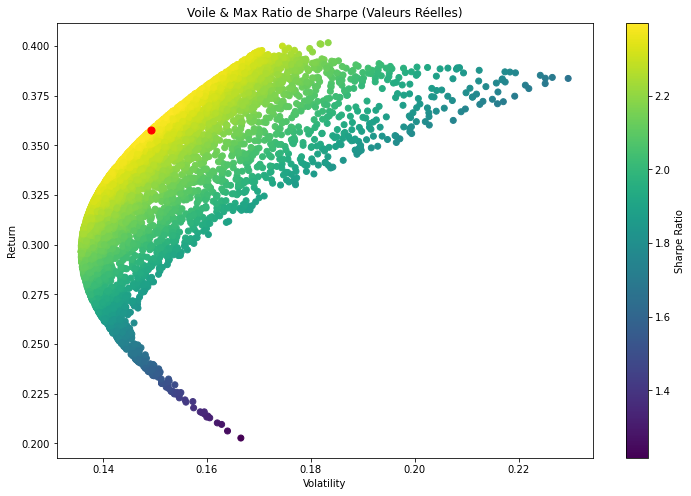

In [0]:
plt.figure(figsize=(12,8))
plt.scatter(vol_arr, ret_arr, c=sharpe_arr, cmap='viridis')
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Volatility')
plt.ylabel('Return')
plt.title('Voile & Max Ratio de Sharpe (Valeurs Réelles)')
plt.scatter(max_sr_vol, max_sr_ret,c='red', s=50) # red dot
plt.show()

In [0]:
# Ptf Ratio de sharpe maximum pour sample
weight_max_sharpe_ratio_pf_sample=all_weights[sharpe_arr.argmax(),:]
print('Le portefeuille maximisant le ratio de sharpe à partir des valeurs réelles est:')
print(weight_max_sharpe_ratio_pf)
print('Pour un rendement de :', round(ret_arr[sharpe_arr.argmax()]*100, 2), '%')
print('Et une volatilité de :', round(vol_arr[sharpe_arr.argmax()]*100, 2), '%')
print('Pour un ratio de Sharpe de: ', sharpe_arr.max())

# Verification somme poids = 1
check_sum(weight_max_sharpe_ratio_pf_sample)

Le portefeuille maximisant le ratio de sharpe à partir des valeurs réelles est:
[4.13802018e-01 5.85933318e-01 2.64664045e-04]
Pour un rendement de : 35.77 %
Et une volatilité de : 14.92 %
Pour un ratio de Sharpe de:  2.3971784429943916


0.0

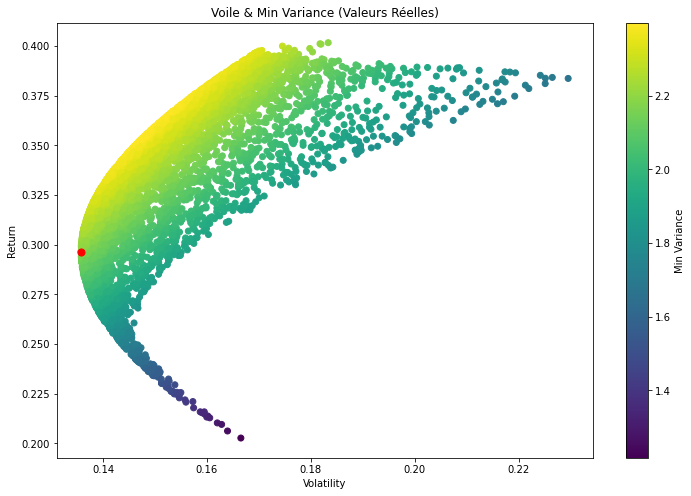

In [0]:
# Ptf min variance
plt.figure(figsize=(12,8))
plt.scatter(vol_arr, ret_arr, c=sharpe_arr, cmap='viridis')
plt.colorbar(label='Min Variance')
plt.xlabel('Volatility')
plt.ylabel('Return')
plt.title('Voile & Min Variance (Valeurs Réelles)')
plt.scatter(vol_arr[vol_arr.argmin()], ret_arr[vol_arr.argmin()],c='red', s=50) # red dot
plt.show()

In [0]:
# Ptf min variance
weight_min_var_pf_sample=all_weights[vol_arr.argmin(),:]
print('Le portefeuille Min-Variance à partir des valeurs réelles est:')
print(weight_min_var_pf_sample)
print('Pour un rendement de :', round(ret_arr[vol_arr.argmin()]*100, 2), '%')
print('Et une volatilité de :', round(vol_arr[vol_arr.argmin()]*100, 2), '%')
print('Pour un ratio de Sharpe de: ', sharpe_arr[vol_arr.argmin()])

# Verification somme poids = 1
check_sum(weight_min_var_pf_sample)

Le portefeuille Min-Variance à partir des valeurs réelles est:
[0.31060108 0.18164028 0.50775864]
Pour un rendement de : 29.65 %
Et une volatilité de : 13.58 %
Pour un ratio de Sharpe de:  2.183359828237362


0.0

3. Application des portefeuilles aux vrais valeurs

In [0]:
# Application du ptf Min-Variance
res_min_var_sample=get_ret_vol_sr(weight_min_var_pf_sample)
res_shapre_sample=get_ret_vol_sr(weight_max_sharpe_ratio_pf_sample)

print("Min Var Sample",res_min_var_sample,"Sharpe sample", res_shapre_sample)

Min Var Sample [0.12577534 0.0916525  1.37230681] Sharpe sample [0.12577534 0.08431696 1.49169688]
